# Lecture : Shallow Graph Feature Learning

## Lab 01 : Deepwalk - Exercise

### Xavier Bresson   

Perozzi, Al-Rfou, Skiena, Deepwalk: Online learning of social representations, 2014  
https://arxiv.org/pdf/1403.6652.pdf

Notebook goals :<br> 
• Design a random walk extractor <br> 
• Implement the deepwalk technique <br> 
• Compare visually the deepwalk embedding with networkx visualization <br> 


In [ ]:
# # For Google Colaboratory
# import sys, os
# if 'google.colab' in sys.modules:
#     # mount google drive
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     path_to_file = '/content/gdrive/My Drive/CS5284_2024_codes/codes/07_Shallow_Learning'
#     print(path_to_file)
#     # change current path to the folder containing "path_to_file"
#     os.chdir(path_to_file)
#     !pwd
#     !pip install rdkit==2024.03.5 # Install RDKit
#     !pip install dgl==1.0.0 # Install DGL


In [1]:
# Libraries
import pickle
import sys; sys.path.insert(0, 'lib/')
from lib.utils import Molecule
from rdkit import Chem
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt
import random 
from lib.utils import compute_ncut


# Load dataset and select one molecule

Loading data
tensor([0, 5, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 4, 0, 0, 0, 2])
tensor([ 0,  0,  1,  2,  3,  4,  0,  0,  5,  6,  7,  8,  9, 10,  1, 11,  1, 12,
         0, 13, 14, 15,  2])
tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
        [0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0

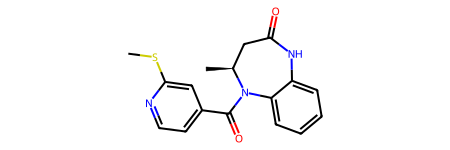

In [3]:
print('Loading data')
data_folder_pytorch = 'datasets/ZINC_pytorch/'
with open(data_folder_pytorch+"train_pytorch.pkl","rb") as f:
    dataset=pickle.load(f)

# Select one molecule
idx = 12
mol = dataset[idx]
print(mol.atom_type)
print(mol.atom_type_pe)
print(mol.bond_type)
print(mol.bag_of_atoms)
print(mol.logP_SA_cycle_normalized)
print(mol.smile)
Chem.MolFromSmiles(mol.smile)


# Write a class for extracting a random walk path and test it

In [ ]:
class sample_RW_path:
    
    def __init__(self, num_steps, RW):
        self.num_steps = num_steps # number of steps
        self.RW = RW # random walk matrix
        self.num_nodes = RW.size(0) # number of nodes
        
    def sample_walk(self, idx_start):
        idx = torch.tensor(idx_start).long() # starting index of the walk
        RWpath = [idx] # random walk path
        for _ in range(self.num_steps-1):
        #for _ in range(### YOUR CODE HERE): # sample "num_steps-1" nodes
            # sample the next node from the RW probability prob_j = sample(RW[i,:]
            # use Bernoulli sampling with torch.distributions.Categorical(prob).sample()
            idx =  ### YOUR CODE HERE
            RWpath.append(idx) # append sampled node to the path
        RWpath = torch.stack(RWpath).flatten() # path format = torch.tensor([idx_1, idx_2, ..., idx_num_steps])
        return RWpath

# RW operator
A = (mol.bond_type>0).float() # Adjacency matrix
D = A.sum(dim=0) # Degree vector
Dinv = (D**(-1)).diag() # Inverse degree matrix
RW = torch.mm(Dinv,A) # RW matrix
#print(RW)
#print(RW.sum(dim=1)) # sanity check, probability sums to 1

# Sample one RW path
num_RW_steps = 4 # QM9
num_RW_steps = 12 # ZINC
generator = sample_RW_path(num_RW_steps, RW) # instantiate RW class
walk = generator.sample_walk(7) # sample RW path starting with index=7
print('RW:',walk)

# Check visually RW path correctness
fig = plt.figure()
ax = fig.add_subplot(111)
A_nx = nx.from_numpy_array(A.numpy())
C = compute_ncut(A.long(), 4)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Molecule visualization with networkx')
plt.show()


# Write a class of deepwalk network and test it

In [ ]:
class deepwalk_net(nn.Module): 
    
    def __init__(self, num_nodes, hidden_dim, num_negative):
        super(deepwalk_net, self).__init__()
        print(num_nodes, hidden_dim)
        self.num_nodes = num_nodes
        self.num_negative = num_negative
        self.node_embedding = nn.Embedding(num_nodes, hidden_dim)

    def forward(self, walk):
        walk_list = walk.tolist() # list nodes in RW
        node_list = list(range(self.num_nodes)) # list all nodes
        list_negative = torch.tensor(list(set(node_list) - set(walk_list))) # all possible negative samples
        #list_negative = list_negative[torch.randperm(list_negative.size(0))] # ???
        loss = []
        for i in walk: # loop over all nodes in RW
                       # node i that must predict all other nodes j in RW
                
            # positive samples
            # extract embedding hi of node i
            # hi.size()=(1,hidden_dim), you may use ".unsqueeze()"
            hi = ### YOUR CODE HERE
            # extract embedding hj of nodes j in RW
            j = torch.tensor(list(set(walk_list) - set([i.detach().item()]))) # all other nodes j in RW
            # hj.size()=(num_RW_steps-1,hidden_dim), you may use ".transpose()"
            hj = ### YOUR CODE HERE
            
            # negative samples : select randomly "num_negative" nodes which are not in the RW path
            list_negative = list_negative[torch.randperm(list_negative.size(0))][:self.num_negative] # select randomly "num_negative" negative samples
            # extract embedding hk of nodes k not in RW 
            # hk.size()=(num_negative,hidden_dim), you may use ".transpose()"
            hk = ### YOUR CODE HERE
            
            # compute loss
            loss_i = - ( torch.log(torch.sigmoid(torch.mm(hi,hj))).sum() - 0.25*torch.log(torch.sigmoid(torch.mm(hi,hk))).sum() )
            loss.append(loss_i)
        loss = torch.stack(loss).mean()
        return loss

# Instantiate a deepwalk network
num_nodes = A.size(0)
net = deepwalk_net(num_nodes, 2, num_RW_steps//4) # select num_negative = num_RW_steps/4
print(net)

# Train the network
optimizer = torch.optim.Adam( net.parameters() , lr=0.001 ) 
for iter in range(300): 
    loss_epoch = 0.0
    for idx in torch.randperm(num_nodes).tolist(): # shuffle ordering of nodes
        walk = generator.sample_walk(idx)
        loss = net(walk)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach()
        with torch.no_grad():
            # centering the embedding coordinates
            # helps optimization by reducing one degree of freedom
            net.node_embedding.weight.sub_(net.node_embedding.weight.mean(dim=0)) 
    # plot the loss value
    if not iter%10:
        print(iter,loss_epoch/num_nodes)
            
# Visualize the 2D coordinates of the node embeddings
x = net.node_embedding.weight.detach()
print(x,x.size())

# plot 2D coordinates
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x[:,0], x[:,1])
idx = list(range(num_nodes))
ax.scatter(x[:,0], x[:,1], c=C, cmap='jet')
for i, txt in enumerate(idx):
    ax.annotate(txt, (x[:,0][i], x[:,1][i]), textcoords="offset points", xytext=(1,5))
ax.title.set_text('2D embdding of nodes')
plt.show()
    

In [ ]:
# Compare with graph edges
fig = plt.figure()
ax = fig.add_subplot(111)
nx.draw(A_nx, ax=ax, node_color=C, cmap='jet', with_labels=True, font_size=10) # visualise node indexes
ax.title.set_text('Molecular graph')
plt.show()
